<a href="https://colab.research.google.com/github/giordanovitale/Potato/blob/main/LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0 - Imports and Kaggle setup**

## Imports

In [ ]:
!pip install category_encoders
!pip install eli5
!pip install shap

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive/Bayesian Analysis")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly

import category_encoders as ce
from category_encoders import TargetEncoder

import sklearn
import imblearn
import xgboost as xgb

import sklearn.metrics as metrics

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression, BayesianRidge, Ridge

import pymc as pm
import arviz as az

import shap
import eli5

pd.set_option('display.max_columns', None)

## Kaggle setup

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'

In [ ]:
!kaggle datasets download -d nikhilbhathi/data-scientist-salary-us-glassdoor

Dataset URL: https://www.kaggle.com/datasets/nikhilbhathi/data-scientist-salary-us-glassdoor
License(s): CC0-1.0
data-scientist-salary-us-glassdoor.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

 bayesian_lr_model.pkl			  helper_functions.py	    __pycache__
 bayesian_tree				  LR.ipynb		    Salary_Prediction.ipynb
 bike_sales_data.csv			  onlinefoods.csv	    Untitled.ipynb
 data_cleaned_2021.csv			 'Outline and ideas.docx'
 data-scientist-salary-us-glassdoor.zip   project.ipynb


In [ ]:
import zipfile

zip_file_path = "data-scientist-salary-us-glassdoor.zip"

# Define the directory where you want to extract the contents
extract_dir = "."

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall(extract_dir)

# Optionally, you can remove the zip file after extraction
os.remove(zip_file_path)

FileNotFoundError: [Errno 2] No such file or directory: 'data-scientist-salary-us-glassdoor.zip'

## Functions

In [ ]:
def get_data(string):
    data = pd.read_csv(string)
    data.drop(['index',
               'Founded',
               'Rating',
               'Job Title',
               'Salary Estimate',
               'Job Description',
               'Company Name',
               'Location',
               'Headquarters',
               'Industry',
               'Competitors',
               'Hourly',
               'Employer provided',
               'company_txt',
               'Job Location',
               'seniority_by_title',
               'Lower Salary',
               'Upper Salary',
               'Degree'], axis=1, inplace=True)



    for col in data.columns:
        data[col] = data[col].replace('-1', pd.NA)
        data[col] = data[col].replace('na', pd.NA)
        data[col] = data[col].replace(-1, pd.NA)
        data[col] = data[col].replace('unknown', pd.NA)
        data[col] = data[col].replace('Unknown / Non-Applicable', pd.NA)

    data.dropna(inplace=True)
    data.drop_duplicates(inplace=True)


    return data

In [ ]:
def inspect_data(data):
    print(data.head(3))
    print('#############################################################')
    print("Shape:\n", data.shape)
    print('#############################################################')
    print("Info:\n", data.info())
    print('#############################################################')
    print('Null values:\n', data.isnull().sum())
    print('#############################################################')






In [ ]:
def target_encode_dfs(train_df, val_df, cat_cols, target_col):

    revenue_mapping = {'$1 to $5 million (USD)': 0,
                        '$5 to $10 million (USD)': 1,
                        '$10 to $25 million (USD)': 2,
                        '$25 to $50 million (USD)': 3,
                        '$50 to $100 million (USD)': 4,
                        '$100 to $500 million (USD)': 5,
                        '$500 million to $1 billion (USD)': 6,
                        '$1 to $2 billion (USD)': 7,
                        '$2 to $5 billion (USD)': 8,
                        '$5 to $10 billion (USD)': 9,
                        '$10+ billion (USD)':10}

    # Copy the input DataFrames to avoid modifying them directly
    train_encoded = train_df.copy()
    val_encoded = val_df.copy()

    # Initialize the TargetEncoder
    target_encoder = TargetEncoder(cols=cat_cols)

    # Fit the encoder on the training data
    target_encoder.fit(train_encoded[cat_cols], train_encoded[target_col])

    # Transform the training and validation sets
    train_encoded[cat_cols] = target_encoder.transform(train_encoded[cat_cols])
    val_encoded[cat_cols] = target_encoder.transform(val_encoded[cat_cols])

    train_encoded[cat_cols] = train_encoded[cat_cols].round(4)
    val_encoded[cat_cols] = val_encoded[cat_cols].round(4)

    train_encoded.loc[:, 'Revenue'] = train_encoded['Revenue'].map(revenue_mapping)
    val_encoded.loc[:, 'Revenue'] = val_encoded['Revenue'].map(revenue_mapping)

    # Reverse mapping dictionary for each column
    mapping = {}
    for col in cat_cols:
        mapping[col] = dict(zip(train_df[col],train_encoded[col]))

    return train_encoded, val_encoded, mapping


In [ ]:
def split(data):

    data_shuffled = data.sample(frac=1, random_state=42)  # Shuffle with a fixed random_state for reproducibility

    # Calculate the index to split the data (80% for training, 20% for testing)
    train_size = int(0.8 * len(data_shuffled))

    # Split the data into training and testing sets
    train = data_shuffled.iloc[:train_size]
    test = data_shuffled.iloc[train_size:]

    return train, test

In [ ]:
def minmax_scale_dfs(train_df, test_df):
    # Initialize the scaler
    scaler = MinMaxScaler()

    # Fit the scaler only on the training data
    scaler.fit(train_df)

    # Transform both the training and test data using the same scaler
    train_scaled = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns)
    test_scaled = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

    return train_scaled, test_scaled, scaler

In [ ]:
def feature_eng(X_scaled):

    # Create a column which sums 'Programming Language'
    X_scaled['Programming'] = X_scaled['Python'] + X_scaled['sas']

    # Create a column which sums 'Queries'
    X_scaled['Queries'] = X_scaled['mongo'] + X_scaled['sql']

    # Create a column which sums 'DeepLearning'
    X_scaled['Machine Learning'] = X_scaled['keras'] + X_scaled['pytorch'] + X_scaled['tensor'] + X_scaled['scikit']

    # Create a column which sums 'Dashboards'
    X_scaled['Dashboards'] = X_scaled['bi'] + X_scaled['tableau'] + X_scaled['excel']

    # Create a column which sums 'Cloud'
    X_scaled['Cloud'] = X_scaled['aws'] + X_scaled['google_an']

    # Create a column which sums 'Apache'
    X_scaled['Apache'] = X_scaled['flink'] + X_scaled['spark'] + X_scaled['hadoop']


    X_scaled.drop(['Size', 'Age',
                  'Python', 'spark', 'aws', 'sql', 'sas', 'keras', 'pytorch',
                  'tensor', 'hadoop', 'tableau', 'bi', 'flink', 'mongo', 'google_an',
                  'excel', 'scikit'],
                  axis=1,
                  inplace=True)

    return X_scaled

In [ ]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [ ]:
def reverse_minmax_scaled_value(scaled_value, min_val, max_val):
    """
    Reverse a MinMax scaled value to its original scale.

    Args:
    scaled_value (float): The scaled value to be reversed.
    min_val (float): The minimum value in the original scale.
    max_val (float): The maximum value in the original scale.

    Returns:
    float: The reversed value in the original scale.
    """
    original_value = scaled_value * (max_val - min_val) + min_val
    return original_value


# **1 - Load the data and perform pre-processing steps, including Encoding, Scaling and EDA**

## Getting data

In [ ]:
data = get_data('data_cleaned_2021.csv')

In [ ]:
data.columns

Index(['Size', 'Type of ownership', 'Sector', 'Revenue', 'Avg Salary(K)',
       'Age', 'Python', 'spark', 'aws', 'excel', 'sql', 'sas', 'keras',
       'pytorch', 'scikit', 'tensor', 'hadoop', 'tableau', 'bi', 'flink',
       'mongo', 'google_an', 'job_title_sim'],
      dtype='object')

In [ ]:
inspect_data(data)

### Outlier with InterQuartile Range

During our analysis in subsequent chapters of this notebook, we have noticed that the target variable is affected by severe outliers. Our approach is to identify them, and then to replace them using the `median value` of the target variable itself.

Text(0.5, 1.0, 'BoxPlot for the target variable')

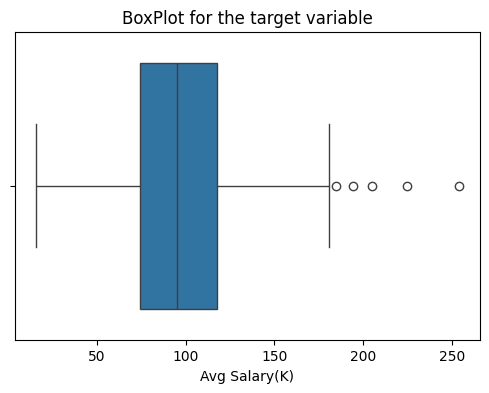

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(data = data, x='Avg Salary(K)')
plt.title('BoxPlot for the target variable')

In [ ]:
Q1 = data['Avg Salary(K)'].quantile(0.25)
Q3 = data['Avg Salary(K)'].quantile(0.75)

IQR = Q3 - Q1

# Define lower and upper bounds for outliers for the 'Avg Salary(K)' column
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers in the 'Avg Salary(K)' column
outliers = (data['Avg Salary(K)'] < lower_bound) | (data['Avg Salary(K)'] > upper_bound)

# Count outliers in the 'Avg Salary(K)' column
outlier_count = outliers.sum()

# Display the modified DataFrame
print("Outliers detected:", outlier_count)


data = data[(data['Avg Salary(K)'] >= lower_bound) & (data['Avg Salary(K)'] <= upper_bound)]

Outliers detected: 5


Text(0.5, 1.0, 'BoxPlot for the target variable - after the outlier deletion')

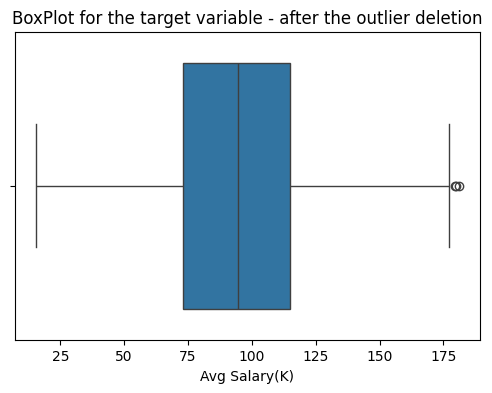

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(data = data, x='Avg Salary(K)')
plt.title('BoxPlot for the target variable - after the outlier deletion')

In [ ]:
data = feature_eng(data)
data.head()

,Type of ownership,Sector,Revenue,Avg Salary(K),job_title_sim,Programming,Queries,Machine Learning,Dashboards,Cloud,Apache
0,Company - Private,Aerospace & Defense,$50 to $100 million (USD),72.0,data scientist,2,0,0,3,0,0
1,Other Organization,Health Care,$2 to $5 billion (USD),87.5,data scientist,1,0,0,0,0,0
2,Company - Private,Business Services,$100 to $500 million (USD),85.0,data scientist,2,1,0,1,0,1
3,Government,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),76.5,data scientist,1,0,0,0,0,0
5,Company - Public,Real Estate,$1 to $2 billion (USD),95.0,data scientist,1,2,0,2,1,0


In [ ]:
trn, tst = split(data)
trn.head()

,Type of ownership,Sector,Revenue,Avg Salary(K),job_title_sim,Programming,Queries,Machine Learning,Dashboards,Cloud,Apache
333,Company - Public,Information Technology,$10+ billion (USD),62.5,data analitics,0,0,0,1,0,0
644,Company - Private,Biotech & Pharmaceuticals,$25 to $50 million (USD),80.5,other scientist,0,0,0,1,0,0
424,Company - Private,Aerospace & Defense,$10 to $25 million (USD),101.0,data scientist,2,1,0,0,0,0
377,Company - Private,Finance,$50 to $100 million (USD),180.0,data scientist,1,1,0,1,0,0
92,Company - Public,Finance,$1 to $2 billion (USD),85.0,data scientist,2,1,0,0,0,1


## Encoding data

In [ ]:
train_encoded, test_encoded, mapping = target_encode_dfs(trn, tst, ['Type of ownership', 'Sector', 'job_title_sim'],'Avg Salary(K)')
train_encoded.head(1), test_encoded.head(1)

(     Type of ownership    Sector Revenue  Avg Salary(K)  job_title_sim  \
 333           110.4008  102.3409      10           62.5        95.5474   
 
      Programming  Queries  Machine Learning  Dashboards  Cloud  Apache  
 333            0        0                 0           1      0       0  ,
      Type of ownership    Sector Revenue  Avg Salary(K)  job_title_sim  \
 555           110.4008  117.2991      10           84.5        96.4273   
 
      Programming  Queries  Machine Learning  Dashboards  Cloud  Apache  
 555            0        0                 0           0      1       0  )

In [ ]:
mapping

## Scaling data

In [ ]:
train_scaled, test_scaled, scaler = minmax_scale_dfs(train_encoded, test_encoded)
train_scaled.head(1),test_scaled.head(1)

(   Type of ownership    Sector  Revenue  Avg Salary(K)  job_title_sim  \
 0                1.0  0.426693      1.0       0.283988       0.627969   
 
    Programming  Queries  Machine Learning  Dashboards  Cloud  Apache  
 0          0.0      0.0               0.0    0.333333    0.0     0.0  ,
    Type of ownership  Sector  Revenue  Avg Salary(K)  job_title_sim  \
 0                1.0     1.0      1.0       0.416918       0.648767   
 
    Programming  Queries  Machine Learning  Dashboards  Cloud  Apache  
 0          0.0      0.0               0.0         0.0    1.0     0.0  )

In [ ]:
X_train = train_scaled.drop(columns=['Avg Salary(K)'])
y_train = train_scaled['Avg Salary(K)']

X_test = test_scaled.drop(columns=['Avg Salary(K)'])
y_test = test_scaled['Avg Salary(K)']

In [ ]:
X_train.head(3)

,Type of ownership,Sector,Revenue,job_title_sim,Programming,Queries,Machine Learning,Dashboards,Cloud,Apache
0,1.000000,0.426693,1.0,0.627969,0.0,0.0,0.0,0.333333,0.0,0.0
1,0.092447,1.000000,0.3,0.648767,0.0,0.0,0.0,0.333333,0.0,0.0
2,0.092447,0.267302,0.2,1.000000,1.0,0.5,0.0,0.000000,0.0,0.0


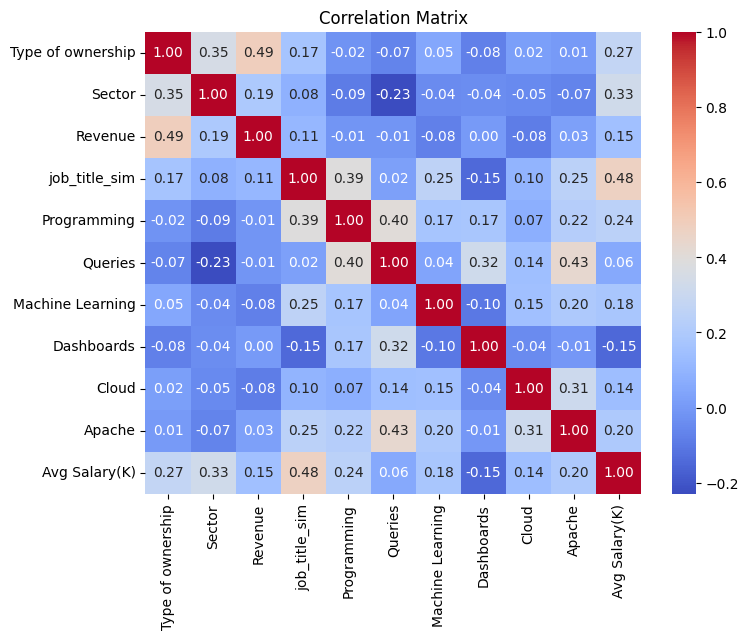

In [ ]:
correlation_matrix = pd.concat([X_train, y_train], axis = 1).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')

plt.show()

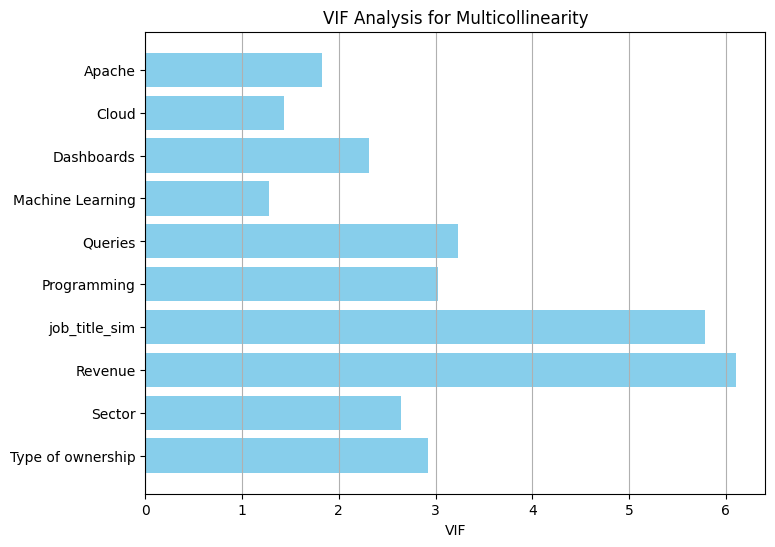

In [ ]:
# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# Plot VIF values
plt.figure(figsize=(8, 6))
plt.barh(vif_data["Feature"], vif_data["VIF"], color='skyblue')
plt.xlabel('VIF')
plt.title('VIF Analysis for Multicollinearity')
plt.grid(axis='x')
plt.show()

## Box plots scaled df

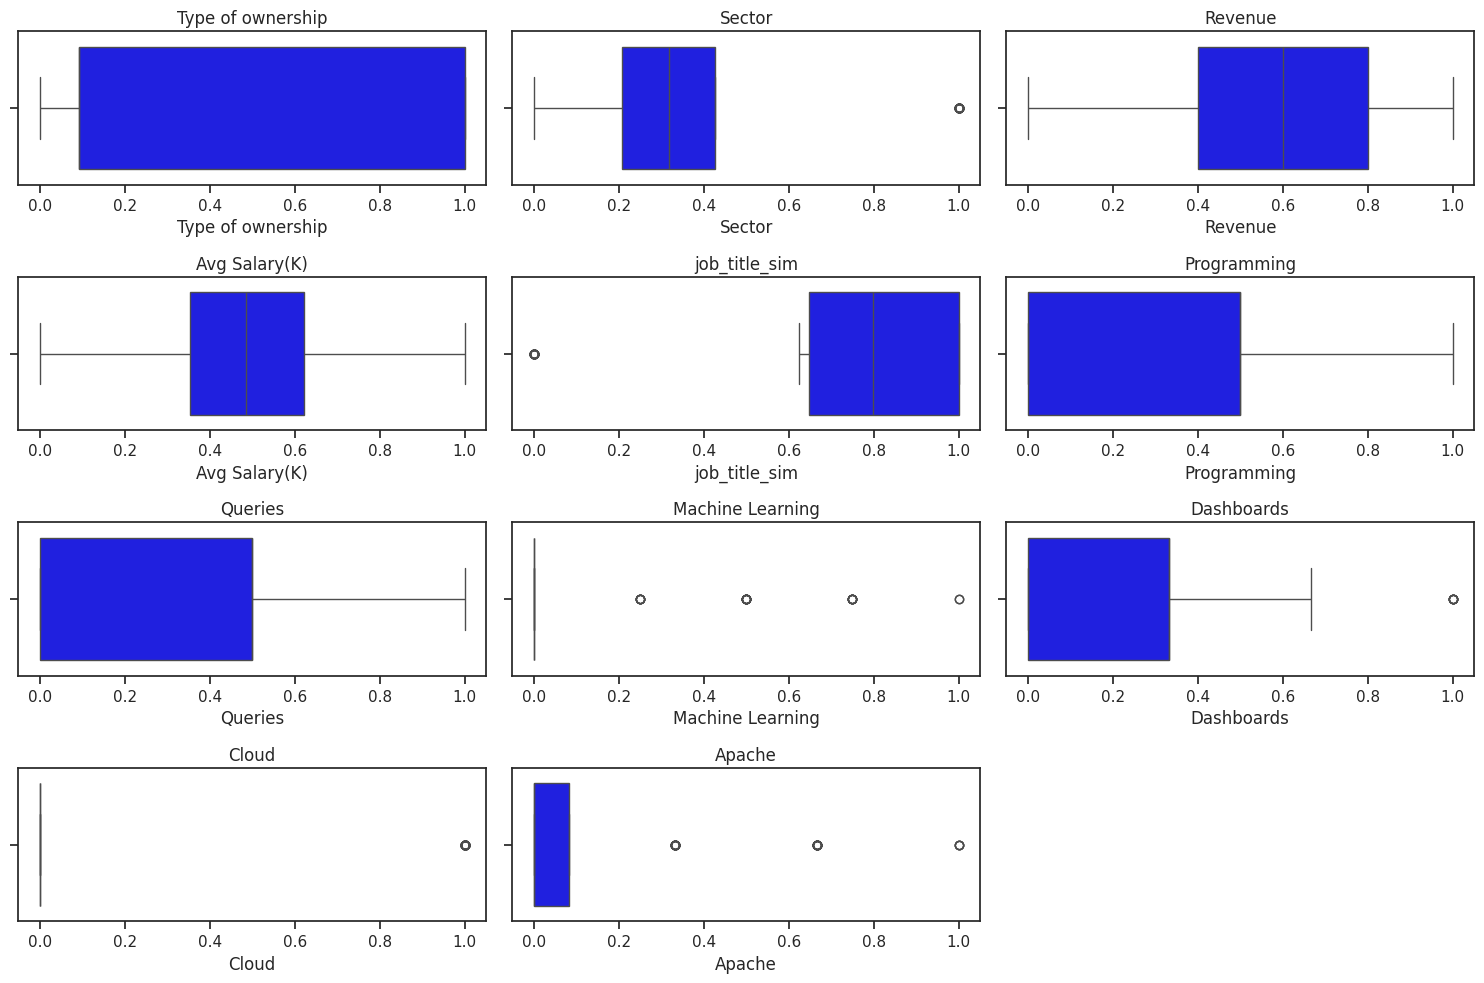

In [ ]:
# Filter numerical and binary columns
numerical_columns = [col for col in train_scaled.columns if train_scaled[col].dtype in ['int64', 'float64']]
binary_columns = [col for col in train_scaled.columns if train_scaled[col].nunique() == 2]

# Define subplot layout for numerical features
num_numerical_columns = len(numerical_columns)
num_rows_numerical = (num_numerical_columns // 3) + (num_numerical_columns % 3 > 0)  # Adjust for odd number of numerical columns

# Create subplots for numerical features
fig, axes = plt.subplots(num_rows_numerical, 3, figsize=(15, 10))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot box plots for numerical features
for i, column in enumerate(numerical_columns):
    color = 'blue'  # Default color for numerical features
    if column in binary_columns:
        color = 'red'  # Change color for binary features
    sns.boxplot(x=train_scaled[column], ax=axes[i], color=color)
    axes[i].set_title(column)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

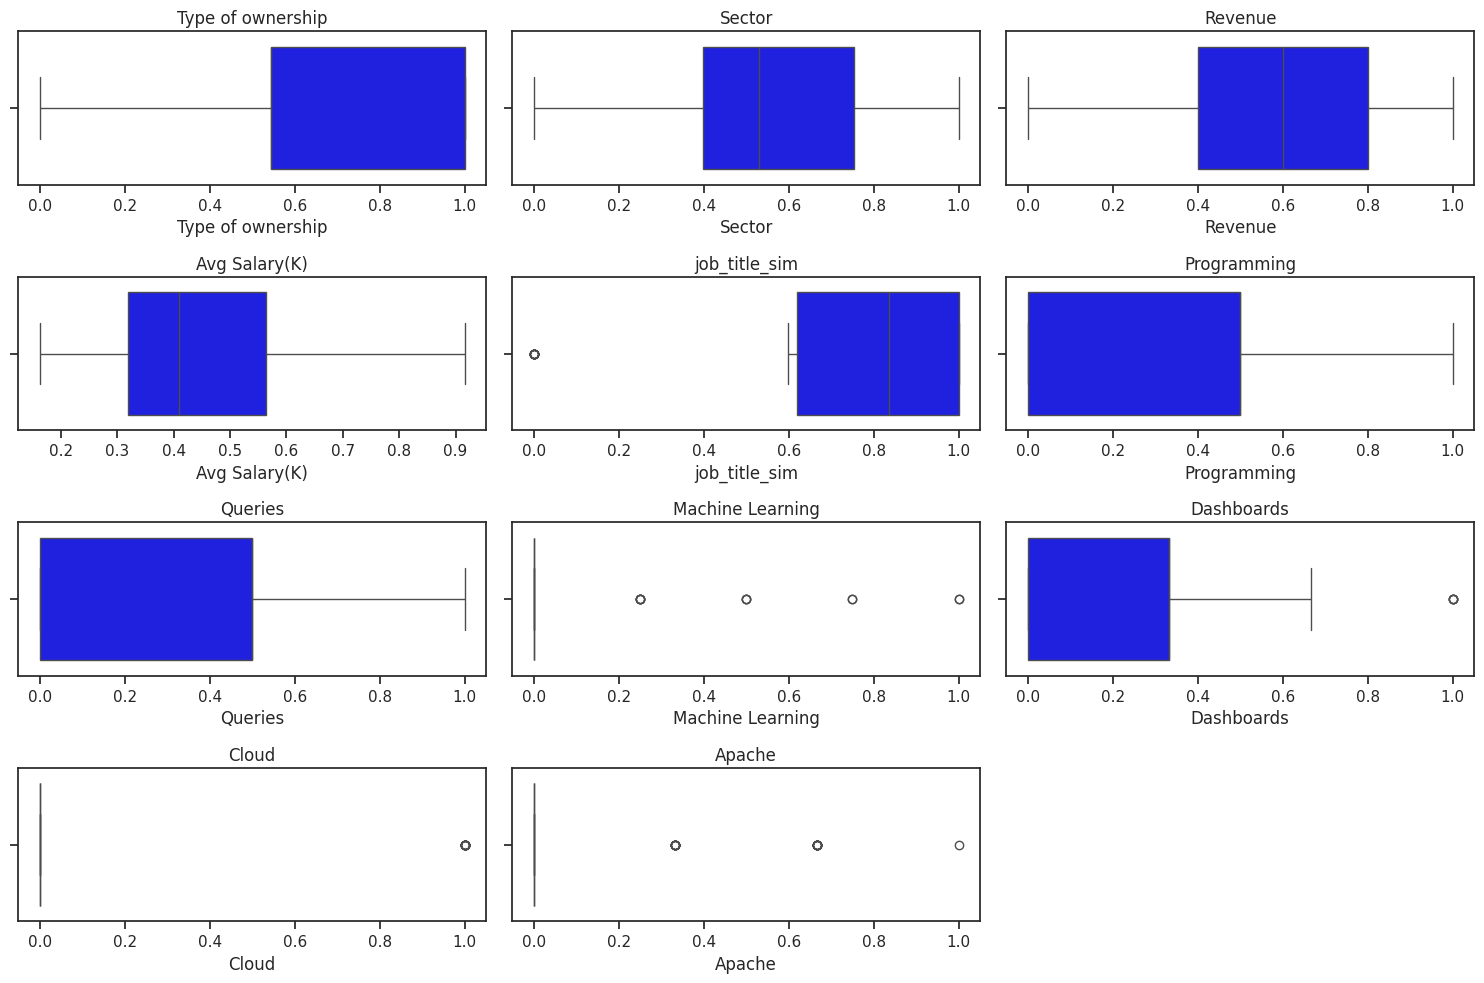

In [ ]:
# Filter numerical and binary columns
numerical_columns = [col for col in test_scaled.columns if test_scaled[col].dtype in ['int64', 'float64']]
binary_columns = [col for col in test_scaled.columns if test_scaled[col].nunique() == 2]

# Define subplot layout for numerical features
num_numerical_columns = len(numerical_columns)
num_rows_numerical = (num_numerical_columns // 3) + (num_numerical_columns % 3 > 0)  # Adjust for odd number of numerical columns

# Create subplots for numerical features
fig, axes = plt.subplots(num_rows_numerical, 3, figsize=(15, 10))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot box plots for numerical features
for i, column in enumerate(numerical_columns):
    color = 'blue'  # Default color for numerical features
    if column in binary_columns:
        color = 'red'  # Change color for binary features
    sns.boxplot(x=test_scaled[column], ax=axes[i], color=color)
    axes[i].set_title(column)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# Initialize an empty dictionary
models_dict = {}
predictions_dict={}

# **2 - Linear Regression, including frequentist and Bayesian approaches**

## frequentist LR

In [ ]:
def freq_lr(X_train,y_train, X_test ):
  normal_lr = LinearRegression()
  normal_lr.fit(X_train, y_train)

  y_val_predictions_nlr = normal_lr.predict(X_test)

  return normal_lr , y_val_predictions_nlr

In [ ]:
normal_lr, y_val_predictions_nlr = freq_lr(X_train,y_train, X_test)


models_dict['Frequentist LinReg'] = normal_lr
predictions_dict['Frequentist LinReg'] = y_val_predictions_nlr

In [ ]:
regression_results(y_test, y_val_predictions_nlr)

explained_variance:  0.1739
mean_squared_log_error:  0.0088
r2:  0.1385
MAE:  0.1163
MSE:  0.0195
RMSE:  0.1395


In [ ]:
models_dict, predictions_dict

({'Frequentist LinReg': LinearRegression()},
 {'Frequentist LinReg': array([0.64854501, 0.3848102 , 0.53658248, 0.37659451, 0.31033763,
         0.59352251, 0.37634303, 0.63992248, 0.61787945, 0.3848102 ,
         0.55611967, 0.52613882, 0.7166287 , 0.23121222, 0.37112127,
         0.31277211, 0.4834586 , 0.592001  , 0.62858901, 0.48221112,
         0.46351762, 0.4752408 , 0.50638016, 0.67225694, 0.56416753,
         0.52613882, 0.3610218 , 0.4812418 , 0.5399521 , 0.17736789,
         0.19997913, 0.49278349, 0.52004099, 0.44540768, 0.54946263,
         0.53151498, 0.3848102 , 0.45693065, 0.57675345, 0.54724882,
         0.27941762, 0.64854501, 0.74494747, 0.56085201, 0.61915288,
         0.48619695, 0.72426014, 0.5470381 , 0.5161302 , 0.40934072,
         0.48567155, 0.48498957, 0.27816041, 0.60199069, 0.55310691,
         0.60711946, 0.26795476, 0.61307312, 0.53051674, 0.47049868,
         0.21342839])})

## bayesian LR - non informative Normal priors

How to model the prior distributions?
- all the skills variables can be modeled using a Bernoulli Distribution, since they are dummy variables;
- Size can be modeled using a uniform distribution defined between size.min() and size.max()
- Type of ownership can be modeled using a uniform distribution defined between Type of ownership.min() and Type of ownership.max()
- Sector can be modeled using a uniform distribution defined between Sector.min() and Sector.max()
- Revenue can be modeled using a uniform distribution defined between Revenue.min() and Revenue.max()
- job_title_sim can be modeled using a uniform distribution defined between job_title_sim.min() and job_title_sim.max()

In [242]:
def bayesian_lr(X_train, y_train, m = 0.714334089609704, s= 3.603553891795412, samples = 1113, tune = 1722,cores =1):
  # Define Bayesian Linear Regression model
  with pm.Model() as bayesian_lr_model:
      # Priors for coefficients
      beta_0 = pm.Normal('intercept', mu=m, sigma= s)  # Prior for intercept
      beta = pm.Normal('beta', mu=m, sigma=s , shape=X_train.shape[1])  # Prior for coefficients

      # Linear regression equation
      mu = beta_0 + pm.math.dot(beta, X_train.values.T)

      # Likelihood (sampling distribution)
      sigma = pm.HalfNormal('sigma', sigma= s)  # Prior for the standard deviation of the noise
      y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_train.values)  # Likelihood function

      # Sample from the posterior distribution
      trace = pm.sample(samples, tune=tune, cores=cores)


      return trace


In [243]:
trace_bayesian_lr = bayesian_lr(X_train,y_train , m = 0, s= 10, samples = 2000, tune = 1000,cores =1)

array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

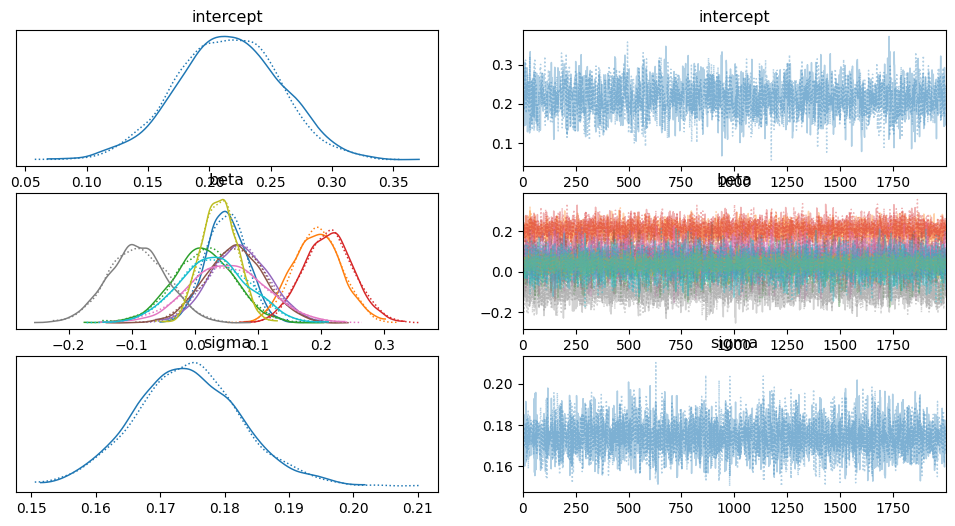

In [ ]:
# Plot posterior distributions
pm.plot_trace(trace_bayesian_lr)

In [ ]:
# Summarize posterior statistics
pm.summary(trace_bayesian_lr)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.215,0.042,0.132,0.289,0.001,0.001,2300.0,2681.0,1.0
beta[0],0.049,0.032,-0.009,0.111,0.001,0.000,3737.0,3050.0,1.0
beta[1],0.194,0.038,0.121,0.264,0.000,0.000,5884.0,3292.0,1.0
beta[2],0.014,0.049,-0.079,0.106,0.001,0.001,2694.0,2608.0,1.0
beta[3],0.211,0.040,0.133,0.282,0.001,0.001,3048.0,2875.0,1.0
beta[4],0.070,0.046,-0.019,0.154,0.001,0.001,3627.0,2907.0,1.0
beta[5],0.064,0.048,-0.027,0.152,0.001,0.001,3321.0,3039.0,1.0
beta[6],0.051,0.062,-0.063,0.172,0.001,0.001,6252.0,3330.0,1.0
beta[7],-0.091,0.047,-0.175,-0.001,0.001,0.000,4438.0,3018.0,1.0
beta[8],0.038,0.028,-0.015,0.089,0.000,0.000,4978.0,3398.0,1.0


In [244]:
def predict_br(trace, X_test):
  coefficients_dict = dict(zip(pm.summary(trace)['mean'][:11].index,
                        pm.summary(trace)['mean'][:11].values))

  lr_model = LinearRegression()

  # Set Coefficients
  # Extract coefficients from the dictionary
  intercept = np.array(coefficients_dict['intercept'])
  coefficients = np.array(list(coefficients_dict.values())[1:])

  # Set coefficients in the logistic regression model
  lr_model.intercept_ = np.array([intercept])
  lr_model.coef_ = np.array([coefficients])

  # Fit the Model
  y_val_predictions = lr_model.predict(X_test)

  return lr_model, y_val_predictions, coefficients_dict


In [245]:
lr_model, y_val_predictions, coefficients_dict_lr = predict_br(trace_bayesian_lr, X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [246]:
models_dict['Bayesian LinReg - Normal'] = lr_model
predictions_dict['Bayesian LinReg - Normal'] = y_val_predictions

In [247]:
regression_results(y_test, y_val_predictions)

explained_variance:  0.1754
mean_squared_log_error:  0.0088
r2:  0.14
MAE:  0.1162
MSE:  0.0194
RMSE:  0.1394


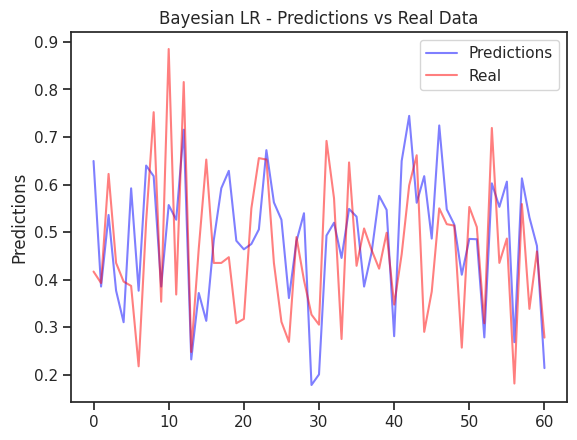

In [248]:
x_axis = np.arange(len(y_test))

plt.plot(x_axis, y_val_predictions, color='blue', alpha=0.5, label='Predictions')
plt.plot(x_axis, y_test, color='red', alpha=0.5, label='Real')
plt.ylabel('Predictions')
plt.title('Bayesian LR - Predictions vs Real Data')
plt.legend()
plt.show()

## Hyper parameter tuning

In [232]:
!pip install scikit-optimize

In [240]:
from skopt import gp_minimize
from skopt.space import Real, Integer

# Define the objective function
def objective(params):
    m, s, samples, tune = params

    # Call your bayesian_lr function with the current set of hyperparameters
    trace_hpt = bayesian_lr(X_train, y_train, m=m, s=s, samples=samples, tune=tune)

    # Calculate the loss
    _, y_pred, _ = predict_br(trace_hpt, X_test)
    MAE = mean_absolute_error(y_test, y_pred)

    return MAE

# Define the search space for hyperparameters
space = [
    Real(0, 5, name='m'),
    Real(1, 5, name='s'),
    Integer(1000, 3000, name='samples'),
    Integer(1000, 2000, name='tune'),
#    Integer(1, 4, name='cores')
]

# Perform Bayesian optimization
res = gp_minimize(objective, space, n_calls=10, random_state=42)

# Get the best hyperparameters
best_params = res.x

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [241]:
best_params

[0.714334089609704, 3.603553891795412, 1113, 1722]

## Bayesian Linear Regression - Student-T Priors

The variables will have a suffix "_t" which distinguish them from the previus B-LR which used Normal priors.

In [ ]:
def bayesian_lr_t(X_train, y_train, n=1, m=0, s=10, samples=2000, tune=1000, cores=1):
    # Define Bayesian Linear Regression model with Student's t priors
    with pm.Model() as bayesian_t_model:

        # Priors for coefficients
        intercept_t = pm.StudentT('intercept', nu=n, mu=m, sigma=s)  # Prior for intercept
        beta_t = pm.StudentT('beta', nu=n, mu=m, sigma=s, shape=X_train.shape[1])  # Prior for coefficients

        # Linear regression equation
        mu_t = intercept_t + pm.math.dot(beta_t, X_train.values.T)

        # Likelihood
        sigma_t = pm.HalfStudentT('sigma', nu=n, sigma=s)  # Prior for the standard deviation of the noise
        y_obs_t = pm.Normal('y_obs', mu=mu_t, sigma=sigma_t, observed=y_train.values)  # Likelihood function

        # Sample from the posterior distribution
        trace_t = pm.sample(samples, tune=tune, cores=cores)

    return trace_t


In [ ]:
trace_t = bayesian_lr_t(X_train, y_train, n=1, m=0, s=10, samples=2000, tune=1000, cores=1)

array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

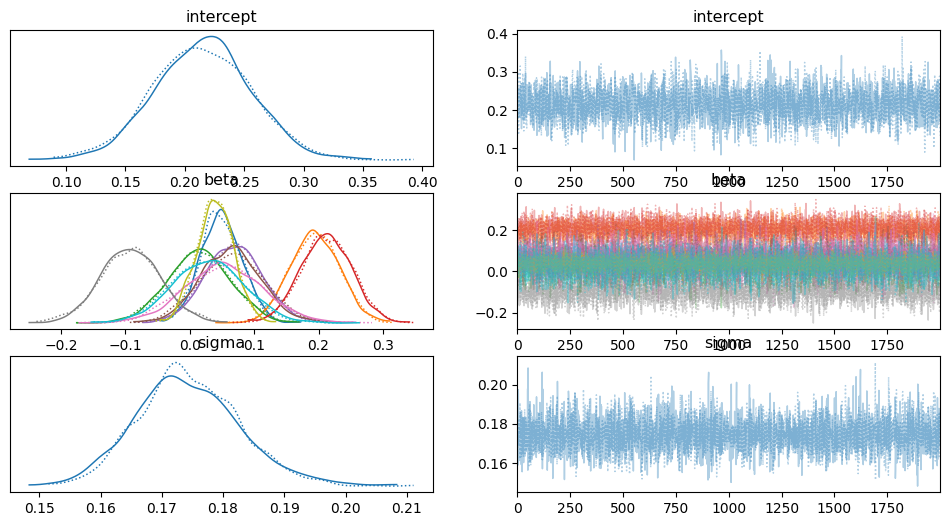

In [ ]:
# Plot posterior distributions
pm.plot_trace(trace_t)

In [ ]:
# Summarize posterior statistics
pm.summary(trace_t)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.215,0.041,0.138,0.291,0.001,0.001,2612.0,2556.0,1.0
beta[0],0.049,0.032,-0.012,0.109,0.001,0.000,3605.0,2616.0,1.0
beta[1],0.194,0.038,0.123,0.264,0.001,0.000,3911.0,3260.0,1.0
beta[2],0.015,0.049,-0.078,0.104,0.001,0.001,2978.0,2916.0,1.0
beta[3],0.212,0.039,0.140,0.287,0.001,0.000,3763.0,3155.0,1.0
beta[4],0.069,0.045,-0.017,0.150,0.001,0.001,3791.0,2901.0,1.0
beta[5],0.064,0.049,-0.028,0.154,0.001,0.001,3492.0,2858.0,1.0
beta[6],0.052,0.061,-0.065,0.163,0.001,0.001,5262.0,3080.0,1.0
beta[7],-0.091,0.047,-0.177,0.002,0.001,0.001,4278.0,2884.0,1.0
beta[8],0.039,0.028,-0.013,0.091,0.000,0.000,5099.0,3088.0,1.0


In [ ]:
lr_model_t, y_val_predictions_t, coefficients_dict_t = predict_br(trace_t, X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [ ]:
models_dict['Bayesian LinReg - StudT'] = lr_model_t
predictions_dict['Bayesian LinReg - StudT'] = y_val_predictions_t

In [ ]:
regression_results(y_test, y_val_predictions_t)

explained_variance:  0.1749
mean_squared_log_error:  0.0088
r2:  0.1379
MAE:  0.1163
MSE:  0.0195
RMSE:  0.1395


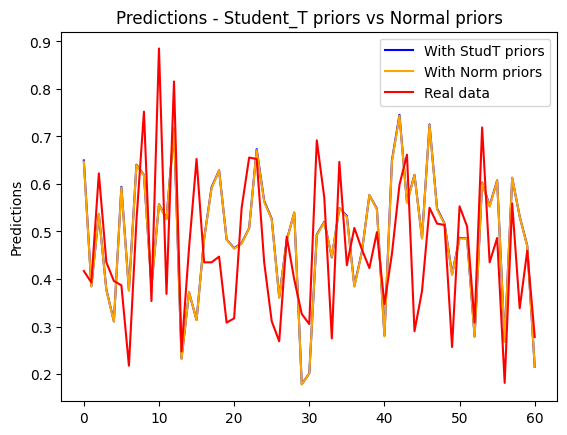

In [ ]:
x_axis = np.arange(len(y_test))

plt.plot(x_axis, y_val_predictions_t, color='blue', label='With StudT priors')
plt.plot(x_axis, y_val_predictions, color='orange', label='With Norm priors')
plt.plot(x_axis, y_test, color='red', label='Real data')
plt.ylabel('Predictions')
plt.title('Predictions - Student_T priors vs Normal priors')
plt.legend()
plt.show()

# **3 - Ridge Regression, inclduing frequentis Ridge and Bayesian Ridge**

## Frequentist Ridge

In [ ]:
ridge = Ridge(alpha=0.8)
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)

mean_absolute_error(y_test, y_pred_ridge)

0.11509540737609043

In [ ]:
models_dict['Frequentist Ridge'] = ridge
predictions_dict['Frequentist Ridge']= y_pred_ridge

## Bayesian Ridge

In [ ]:
# Create and fit the Bayesian Linear Regression model
bayesian_ridge = BayesianRidge()
bayesian_ridge.fit(X_train, y_train)

# Predict on the test set
y_pred_bayesian_ridge = bayesian_ridge.predict(X_test)

# Evaluate the model
regression_results(y_test, y_pred_bayesian_ridge)

explained_variance:  0.2212
mean_squared_log_error:  0.0084
r2:  0.1806
MAE:  0.1128
MSE:  0.0185
RMSE:  0.136


In [ ]:
models_dict['Bayesian_Ridge'] = bayesian_ridge
predictions_dict['Bayesian Ridge'] = y_pred_bayesian_ridge

# **4 - Regression Tree, including frequentist and Bayesian Tree**

## Bayesian Tree

In [ ]:
!ls

 bayesian_lr_model.pkl	 data_cleaned_2021.csv	 onlinefoods.csv	   __pycache__
 bayesian_tree		 helper_functions.py	'Outline and ideas.docx'   Salary_Prediction.ipynb
 bike_sales_data.csv	 LR.ipynb		 project.ipynb		   Untitled.ipynb


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/Bayesian Analysis")
sys.path.append("/content/drive/MyDrive/Bayesian Analysis/bayesian_tree")
sys.path.append("/content/drive/MyDrive/Bayesian Analysis/bayesian_tree/bayesian_decision_tree")

import bayesian_tree
from bayesian_tree import bayesian_decision_tree
from bayesian_tree import examples
from bayesian_decision_tree import classification
from bayesian_decision_tree.regression import PerpendicularRegressionTree

In [ ]:
def b_tree(X_train, y_train, X_test, y_test):
  mu = y_train.mean()
  sd_prior = y_train.std() / 10
  prior_pseudo_observations = 1
  kappa = prior_pseudo_observations
  alpha = prior_pseudo_observations / 2
  var_prior = sd_prior**2
  tau_prior = 1/var_prior
  beta = alpha/tau_prior
  prior = np.array([mu, kappa, alpha, beta])

  model = PerpendicularRegressionTree(
        partition_prior=0.9,
        prior=prior,
        delta=0)

  model.fit(np.array(X_train), np.array(y_train))
  print("-----------------")
  print(model)
  print("-----------------")
  print('Tree depth and number of leaves: {}, {}'.format(model.get_depth(), model.get_n_leaves()))
  print('Feature importance:', model.feature_importance())

  # compute accuracy
  y_pred_train = model.predict(X_train)
  y_pred_bayes_tree = model.predict(X_test)
  accuracy_train = mean_absolute_error(y_train, y_pred_train)
  accuracy_test = mean_absolute_error(y_test, y_pred_bayes_tree)
  info_train = 'Train MAE: {:.4f}'.format(accuracy_train)
  info_test = 'Test MAE:  {:.4f}'.format(accuracy_test)
  print(info_train)
  print(info_test)

  return model, y_pred_bayes_tree



In [ ]:
model, y_pred_bayes_tree = b_tree(X_train, y_train, X_test, y_test)

-----------------
x3=0.6459179332025433
 ├ <0.6459179332025433: y=0.3149426084633249, n=48
 └ ≥0.6459179332025433: x1=0.3001272464556881
    ├ <0.3001272464556881: y=0.48197340623494894, n=91
    └ ≥0.3001272464556881: y=0.6163454228619948, n=101
-----------------
Tree depth and number of leaves: 2, 3
Feature importance: [0.         0.14922292 0.         0.85077708 0.         0.
 0.         0.         0.         0.        ]
Train MAE: 0.1411
Test MAE:  0.1130


This is how the Bayesian Tree looks like:

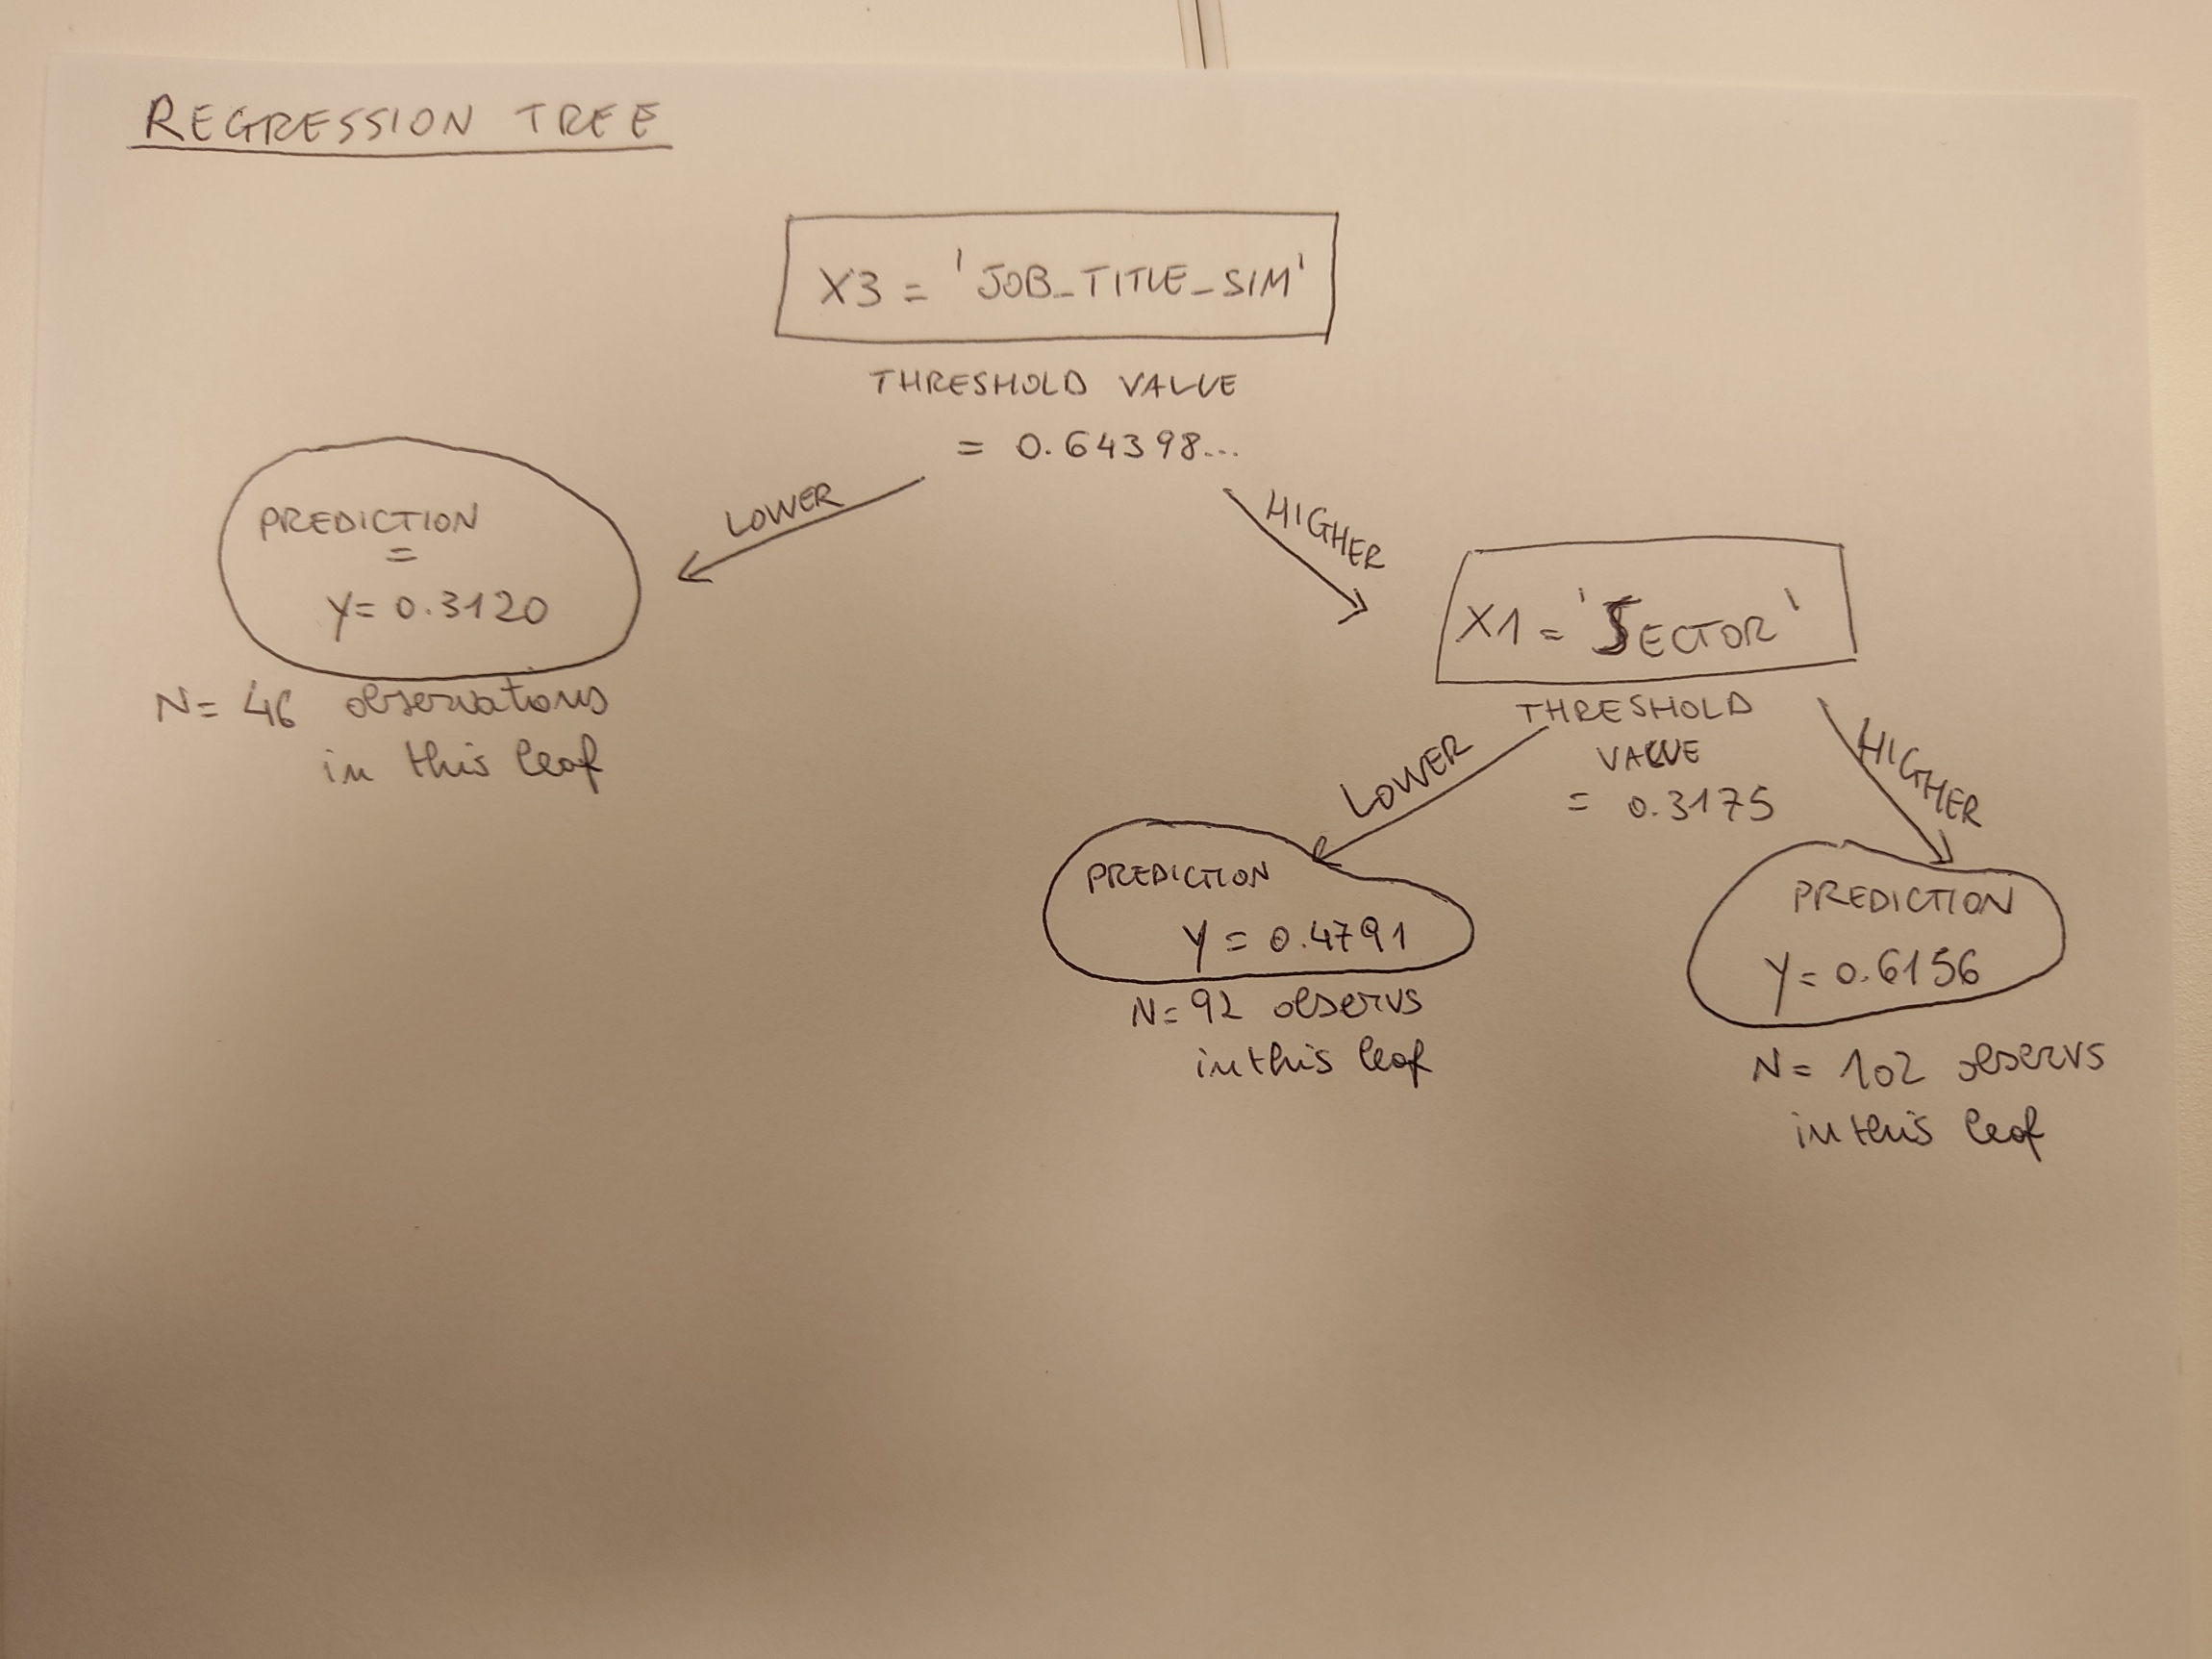

In [ ]:
models_dict['Bayesian Tree'] = model
predictions_dict['Bayesian Tree'] = y_pred_bayes_tree

## Frequentist Bayesian Tree

In [ ]:
def freq_tree(X_train, y_train, X_test, y_test):
  from sklearn.tree import DecisionTreeRegressor
  frequentist_tree = DecisionTreeRegressor(random_state=0,
                                         criterion='absolute_error',
                                         max_depth=3,
                                         min_samples_split=4)

  frequentist_tree.fit(X_train, y_train)

  y_freq_tree_predictions = frequentist_tree.predict(X_test)

  print(f"MAE of the frequentist tree: {mean_absolute_error(y_test, y_freq_tree_predictions)}")

  return frequentist_tree, y_freq_tree_predictions



In [ ]:
frequentist_tree, y_freq_tree_predictions = freq_tree(X_train, y_train, X_test, y_test)

MAE of the frequentist tree: 0.10195136446931802


In [ ]:
models_dict['Frequentist Tree'] = frequentist_tree
predictions_dict['Frequentist Tree'] = y_freq_tree_predictions

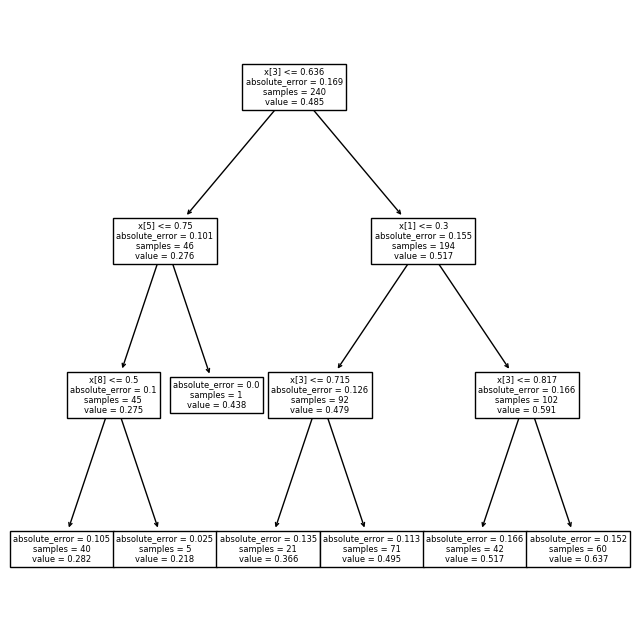

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(8,8))
plot_tree(frequentist_tree)
plt.show()

In [ ]:
models_dict.keys(), predictions_dict.keys()

(dict_keys(['Frequentist LinReg', 'Bayesian LinReg - Normal', 'Bayesian LinReg - StudT', 'Frequentist Ridge', 'Bayesian_Ridge', 'Bayesian Tree', 'Frequentist Tree']),
 dict_keys(['Frequentist LinReg', 'Bayesian LinReg - Normal', 'Bayesian LinReg - StudT', 'Frequentist Ridge', 'Bayesian Ridge', 'Bayesian Tree', 'Frequentist Tree']))

# **5 - Overall Comparison**

In [ ]:
def compare_models(predictions_dict):
  results = {}

  for model, pred in predictions_dict.items():
    results[model] = mean_absolute_error(y_test, pred)


  results_df = pd.DataFrame(results, index=['MAE']).T

  results_df.index.name = 'Models'

  results_df['Model_Type'] = ['Bayesian' if 'Bayesian' in index else 'Frequentist' for index in results_df.index]
  plt.figure(figsize=(11,5))
  sns.barplot(data=results_df, x='MAE', y=results_df.index,
              orient='h', hue='Model_Type')
  plt.title('Overall comparison of models')
  plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
  plt.tight_layout()
  plt.show()

  return results_df

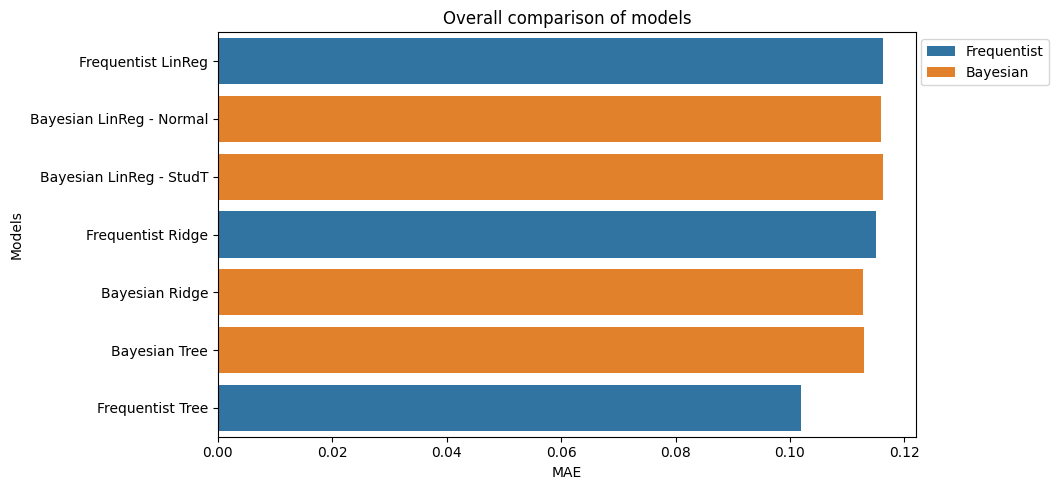

,MAE,Model_Type
Models,,
Frequentist LinReg,0.116294,Frequentist
Bayesian LinReg - Normal,0.115966,Bayesian
Bayesian LinReg - StudT,0.116295,Bayesian
Frequentist Ridge,0.115095,Frequentist
Bayesian Ridge,0.112771,Bayesian
Bayesian Tree,0.112952,Bayesian
Frequentist Tree,0.101951,Frequentist


In [ ]:
results_df = compare_models(predictions_dict)
results_df

# **6 - Feature Importance on Bayesian Lin Reg**

## Simple bar plot

Recall that we already have the coefficients of this model stored in `coefficients_dict`.

In [ ]:
def plot_coef(coefficients_dict):
  mapping_names = {
      'intercept': 'intercept',
      'beta[0]': 'Type of ownership',
      'beta[1]': 'Sector',
      'beta[2]': 'Revenue',
      'beta[3]': 'job_title_sim',
      'beta[4]': 'Programming',
      'beta[5]': 'Queries',
      'beta[6]': 'Machine Learning',
      'beta[7]': 'Dashboards',
      'beta[8]': 'Cloud',
      'beta[9]': 'Apache'
  }

  mapped_coefficients_dict = {mapping_names[key]: value for key, value in coefficients_dict.items()}
  sorted_coefficients = sorted(mapped_coefficients_dict.items(), key=lambda coef_value: np.abs(coef_value[1]), reverse=True)

  # Extract feature names and corresponding coefficients
  feature_names = [item[0] for item in sorted_coefficients]
  coefficients = [item[1] for item in sorted_coefficients]

  sns.set(style="ticks")

  plt.figure(figsize=(11, 6))

  # custom colors for the bars
  for feature, coef in zip(feature_names, coefficients):
      color = 'red' if coef < 0 else 'green'
      plt.barh(feature, coef, color=color, align='center')

  plt.xlabel('Coefficient Magnitude')
  plt.ylabel('Feature')
  plt.title('Feature Importance based on Coefficients')
  plt.gca().invert_yaxis()

  # add annotations
  for feature, coef in zip(feature_names, coefficients):
    if coef>0:
      plt.text(coef, feature, round(coef, 2), va='center', ha='left', fontsize=10)
    else:
      plt.text(coef, feature, round(coef, 2), va='center', ha='right', fontsize=10)

  plt.show()




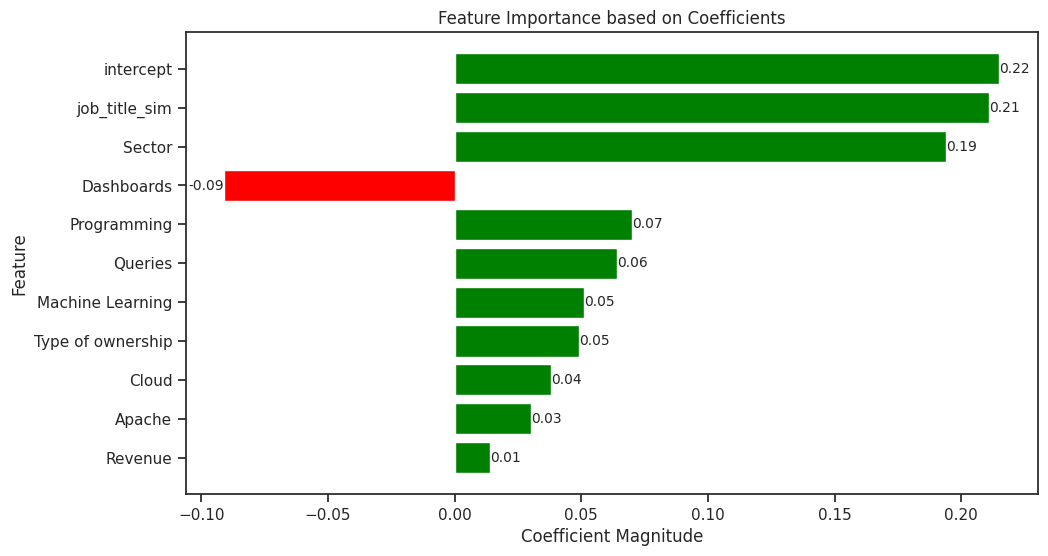

In [ ]:
coefficients_dict = dict(zip(pm.summary(trace_bayesian_lr)['mean'][:11].index,
                        pm.summary(trace_bayesian_lr)['mean'][:11].values))
plot_coef(coefficients_dict)

## SHAP values - using Bayesian Ridge because Bayesian LR creates problems

Reference: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

In [194]:
train_scaled.columns

Index(['Type of ownership', 'Sector', 'Revenue', 'Avg Salary(K)',
       'job_title_sim', 'Programming', 'Queries', 'Machine Learning',
       'Dashboards', 'Cloud', 'Apache'],
      dtype='object')

In [212]:
exp = pd.DataFrame(scaler.inverse_transform(train_scaled))

exp.columns = ['Type of ownership', 'Sector', 'Revenue', 'Avg Salary(K)',
       'job_title_sim', 'Programming', 'Queries', 'Machine Learning',
       'Dashboards', 'Cloud', 'Apache']

exp.drop('Avg Salary(K)', axis=1, inplace=True)

exp.head(3)

,Type of ownership,Sector,Revenue,job_title_sim,Programming,Queries,Machine Learning,Dashboards,Cloud,Apache
0,110.4008,102.3409,10.0,95.5474,0.0,0.0,0.0,1.0,0.0,0.0
1,94.0919,117.2991,3.0,96.4273,0.0,0.0,0.0,1.0,0.0,0.0
2,94.0919,98.1822,2.0,111.2869,2.0,1.0,0.0,0.0,0.0,0.0


In [222]:
exp.columns

Index(['Type of ownership', 'Sector', 'Revenue', 'job_title_sim',
       'Programming', 'Queries', 'Machine Learning', 'Dashboards', 'Cloud',
       'Apache'],
      dtype='object')

In [214]:
# exp['Avg Salary(K)'].iloc[exp.index==203]

In [226]:
explainer = shap.explainers.Linear(bayesian_ridge, exp)
shap_values = explainer(exp)

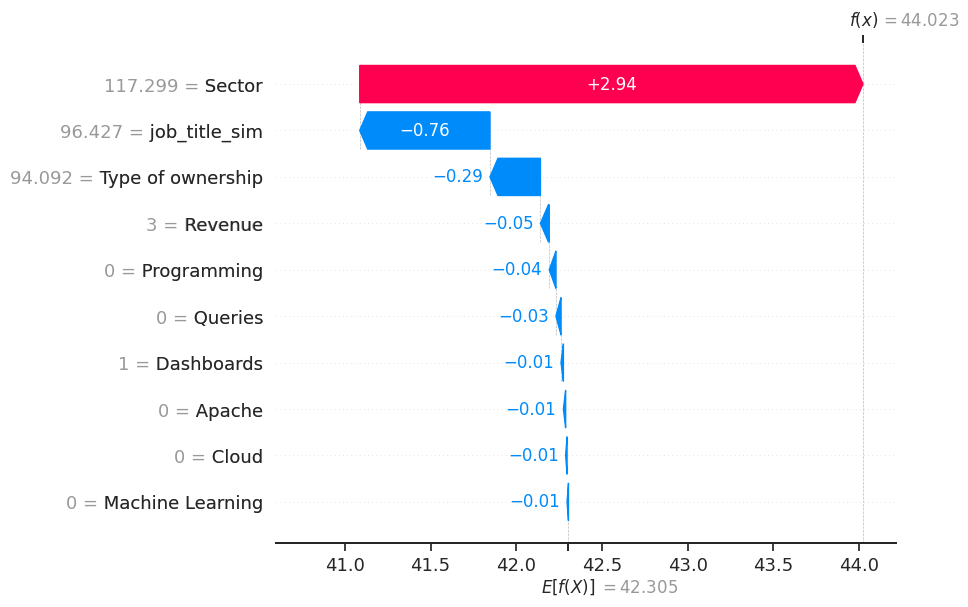

In [227]:
shap.plots.waterfall(shap_values[1], max_display=14)

***

Interpretation of this plot: for the individual having the 21st index in the `X_train`, `having job_title_sim=0` decreased **significantily** his/her salary. I am not sure whether the amount (-0.15) can be interpreted as 15.000$, 15% or what else...

It is important to highlight that this is only a plot for **one single observation** and that the derived conclusions may be different for another individual.

For example, the individual having index 10 in the X_train, has benefitted from the impact of job_title_sim, as its value here is =1.

What also matters is that, for each individual, the predicted value for Salary (SCALED!!!) is 0.495. Starting from this average value, the variables can push the estimate higher or lower, depending on the values they take!

Let's see which are the SHAP values for the individual earning the highest salary.

In [205]:
train_scaled.loc[train_scaled['Avg Salary(K)']==1]

,Type of ownership,Sector,Revenue,Avg Salary(K),job_title_sim,Programming,Queries,Machine Learning,Dashboards,Cloud,Apache
203,0.092447,0.426693,0.2,1.0,0.780705,0.5,0.5,0.5,0.0,0.0,0.333333


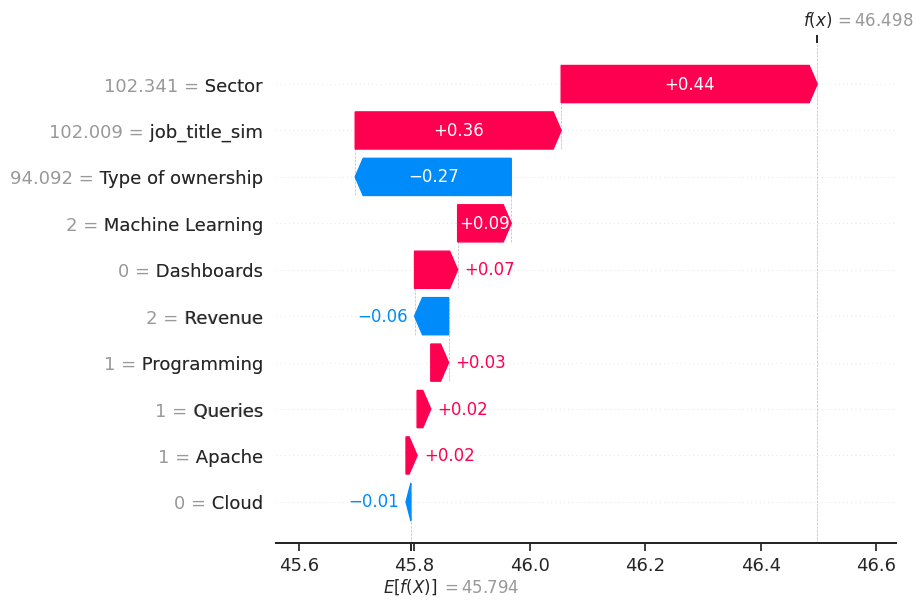

In [206]:
shap.plots.waterfall(shap_values[203], max_display=14)

Overall picture of the variables.
[Source](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/violin.html)

## ELI5

Source:
- https://medium.com/@salonipriyani/explaining-ml-with-eli5-a-guide-for-numerical-computer-vision-and-natural-language-data-e29f18615311#:~:text=ELI5%20can%20be%20used%20to%20explain%20models%20such%20as%20linear,feature%20in%20the%20prediction%20process,
- https://eli5.readthedocs.io/en/latest/autodocs/lime.html?highlight=show_weights#eli5.lime.lime.TextExplainer.show_weights

In [ ]:
eli5.show_weights(models_dict['Bayesian LinReg - Normal'])

Weight?,Feature
+0.213,<BIAS>
+0.213,x3
+0.193,x1
+0.068,x4
+0.066,x5
+0.052,x6
+0.049,x0
+0.039,x8
+0.028,x9
+0.015,x2


# Potential future developments:
- Do the SHAP analysis based on the real values, i.e. the un-scaled values to preserve interpretability,
- Out-of-sample predictions,
- One more prior distribution in the Linear Model,
- Tuning the Bayesian Linear Model: no idea what to tune though

## Out-of-sample predictions

In [ ]:
def encode_oos_data(new_data, type_of_own_mapping, job_title_sim_mapping, sector_mapping):

    new_data.loc[:, 'job_title_sim'] = new_data['job_title_sim'].map(job_title_sim_mapping)
    new_data.loc[:, 'Revenue'] = new_data['Revenue'].map(revenue_mapping)
    new_data.loc[:, 'Type of ownership'] = new_data['Type of ownership'].map(type_of_own_mapping)
    new_data.loc[:, 'Sector'] = new_data['Sector'].map(sector_mapping)

    # Scale the encoded features using Min-Max scaling
    scaler = MinMaxScaler()
    columns_to_scale = ['job_title_sim', 'Revenue', 'Type of ownership', 'Sector', 'Programming', 'Queries', 'Machine Learning', 'Dashboards', 'Cloud', 'Apache']
    new_data[columns_to_scale] = scaler.fit_transform(new_data[columns_to_scale])

    return new_data

In [ ]:
models_dict

{'Frequentist LinReg': LinearRegression(),
 'Bayesian LinReg - Normal': LinearRegression(),
 'Bayesian LinReg - StudT': LinearRegression(),
 'Frequentist Ridge': Ridge(alpha=0.8),
 'Bayesian_Ridge': BayesianRidge(),
 'Bayesian Tree': x3=0.6459179332025433
  ├ <0.6459179332025433: y=0.3149426084633249, n=48
  └ ≥0.6459179332025433: x1=0.3001272464556881
     ├ <0.3001272464556881: y=0.48197340623494894, n=91
     └ ≥0.3001272464556881: y=0.6163454228619948, n=101,
 'Frequentist Tree': DecisionTreeRegressor(criterion='absolute_error', max_depth=3,
                       min_samples_split=4, random_state=0)}

In [ ]:
def out_of_sample_pred(trn, new_data, models_dict):
  en_new = encode_oos_data(new_data, type_of_own_mapping, job_title_sim_mapping, sector_mapping) #processing the new data

  # Initialize an empty dictionary to store predictions
  predictions_dict = {}

  # Iterate through the models dictionary
  for model_name, model in models_dict.items():
      # Make predictions using the model
      predictions = model.predict(en_new)
      # Store the predictions in the predictions dictionary
      predictions_dict[model_name] = predictions

  min_train = min(trn['Avg Salary(K)'])
  max_train = max(trn['Avg Salary(K)'])


  reversed_predictions_dict = {}
  for model_name, predictions in predictions_dict.items():
      reversed_predictions = reverse_minmax_scaled_value(predictions, min_train, max_train)
      reversed_predictions_dict[model_name] = reversed_predictions

  return reversed_predictions_dict

In [ ]:
mapping

{'Type of ownership': {'Company - Public': 110.4008,
  'Company - Private': 94.0919,
  'Subsidiary or Business Segment': 103.5869,
  'Hospital': 93.1012,
  'Nonprofit Organization': 92.4306,
  'Government': 98.6573,
  'Other Organization': 92.9236,
  'School / School District': 93.8843},
 'Sector': {'Information Technology': 102.3409,
  'Biotech & Pharmaceuticals': 117.2991,
  'Aerospace & Defense': 98.1822,
  'Finance': 99.5151,
  'Business Services': 91.208,
  'Insurance': 96.6036,
  'Health Care': 92.4238,
  'Telecommunications': 99.5378,
  'Manufacturing': 97.0747,
  'Media': 101.6746,
  'Government': 97.8047,
  'Real Estate': 100.0784,
  'Oil, Gas, Energy & Utilities': 96.5047,
  'Non-Profit': 91.9326,
  'Agriculture & Forestry': 96.6166,
  'Retail': 101.3625,
  'Travel & Tourism': 93.2272,
  'Transportation & Logistics': 98.5622,
  'Arts, Entertainment & Recreation': 92.4531,
  'Education': 93.8843},
 'job_title_sim': {'data analitics': 95.5474,
  'other scientist': 96.4273,
  'd

In [ ]:
# Initialize empty dictionaries for each column
type_of_own_mapping = {}
job_title_sim_mapping = {}
sector_mapping = {}

# Iterate over the keys of the reverse_mapping dictionary
for col, map in mapping.items():
    if col == 'Type of ownership':
        type_of_own_mapping = map
    elif col == 'job_title_sim':
        job_title_sim_mapping = map
    elif col == 'Sector':
        sector_mapping = map


# Original revenue mapping dictionary
revenue_mapping = {'$1 to $5 million (USD)': 0,
                        '$5 to $10 million (USD)': 1,
                        '$10 to $25 million (USD)': 2,
                        '$25 to $50 million (USD)': 3,
                        '$50 to $100 million (USD)': 4,
                        '$100 to $500 million (USD)': 5,
                        '$500 million to $1 billion (USD)': 6,
                        '$1 to $2 billion (USD)': 7,
                        '$2 to $5 billion (USD)': 8,
                        '$5 to $10 billion (USD)': 9,
                        '$10+ billion (USD)':10}





In [ ]:
new_data = pd.DataFrame({
    "Type of ownership": ['Company - Private', 'Government', 'Company - Public'] ,
    "Sector": ['Media', 'Government', 'Finance'],
    "Revenue": ['$1 to $5 million (USD)', '$10+ billion (USD)', '$100 to $500 million (USD)' ],
    "job_title_sim": ['data scientist', 'data scientist','data scientist'],
    "Programming": [2, 0, 1],
    "Queries": [2, 0, 1],
    "Machine Learning": [2, 0, 1],
    "Dashboards": [2, 0 , 1],
    "Cloud": [2, 0, 1],
    "Apache": [2, 0, 1]
})

In [ ]:
predictions_dict = out_of_sample_pred(trn, new_data,models_dict)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [ ]:
predictions_dict #the numbers are the avg salary (K)

{'Frequentist LinReg': array([109.78939769,  55.74739367,  87.80358698]),
 'Bayesian LinReg - Normal': array([[109.504     ],
        [ 55.50411701],
        [ 87.62510228]]),
 'Bayesian LinReg - StudT': array([[109.504     ],
        [ 55.62328809],
        [ 87.53274919]]),
 'Frequentist Ridge': array([109.48744746,  56.82893332,  88.50898834]),
 'Bayesian_Ridge': array([108.681769  ,  59.31060009,  89.96300996]),
 'Bayesian Tree': array([67.6230017, 67.6230017, 67.6230017]),
 'Frequentist Tree': array([88.  , 62.25, 62.25])}